# TMS Accident Prediction Model

This notebook focuses on building, training, and evaluating machine learning models for accident prediction.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

## 1. Load Preprocessed Data

In [3]:
# Load the preprocessed data
X_train = pd.read_csv('csv_datasets/X_train_scaled.csv')
X_test = pd.read_csv('csv_datasets/X_test_scaled.csv')
y_train = pd.read_csv('csv_datasets/y_train.csv').iloc[:, 0]
y_test = pd.read_csv('csv_datasets/y_test.csv').iloc[:, 0]

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Class distribution in training set:\n{y_train.value_counts()}")

Training set shape: (80, 31)
Testing set shape: (20, 31)
Class distribution in training set:
had_incident
0    77
1     3
Name: count, dtype: int64


## 2. Model Selection and Training

We'll try several models and compare their performance.

In [4]:
# Define models to try
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}\n")

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.7368

Training Random Forest...
Random Forest - Accuracy: 0.9500, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.7368

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9500, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4474

Training SVM...
SVM - Accuracy: 0.9500, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4737

Training Neural Network...
Neural Network - Accuracy: 0.9500, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3158



<Figure size 1500x1000 with 0 Axes>

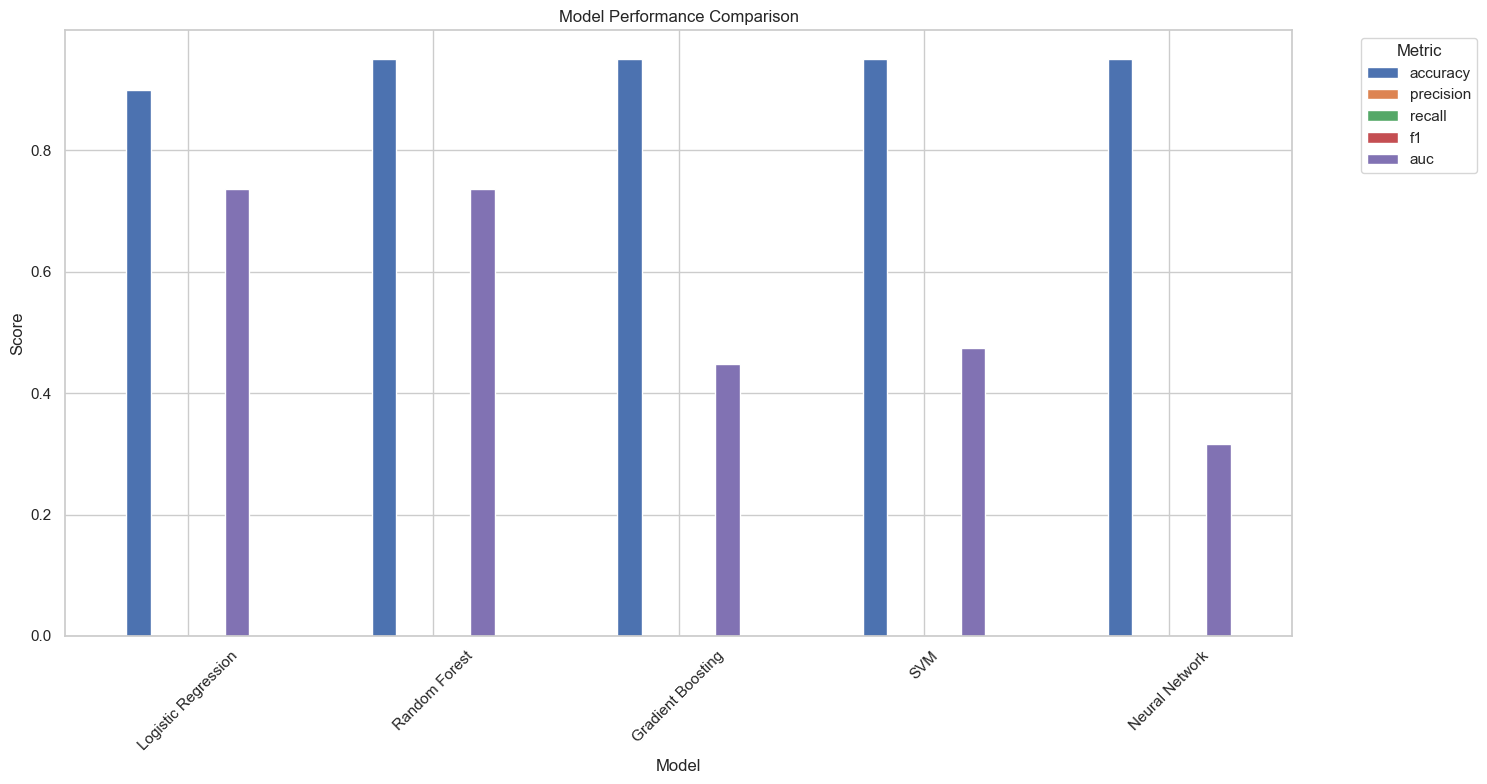

,accuracy,precision,recall,f1,auc
Logistic Regression,0.9,0.0,0.0,0.0,0.736842
Random Forest,0.95,0.0,0.0,0.0,0.736842
Gradient Boosting,0.95,0.0,0.0,0.0,0.447368
SVM,0.95,0.0,0.0,0.0,0.473684
Neural Network,0.95,0.0,0.0,0.0,0.315789


In [5]:
# Compare model performance
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
comparison = pd.DataFrame(index=models.keys(), columns=metrics)

for name in models.keys():
    for metric in metrics:
        comparison.loc[name, metric] = results[name][metric]

# Plot comparison
plt.figure(figsize=(15, 10))
comparison.plot(kind='bar', figsize=(15, 8))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display comparison table
comparison

## 3. Best Model Analysis

Let's analyze the best performing model in more detail.

Best model: Logistic Regression


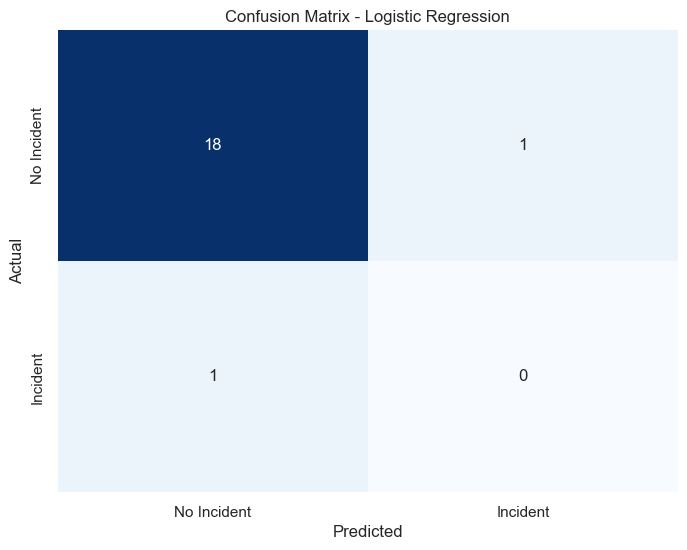

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.00      0.00      0.00         1

    accuracy                           0.90        20
   macro avg       0.47      0.47      0.47        20
weighted avg       0.90      0.90      0.90        20



In [6]:
# Find the best model based on F1 score (balance between precision and recall)
best_model_name = comparison['f1'].idxmax()
best_model = results[best_model_name]['model']
y_pred = results[best_model_name]['y_pred']
y_prob = results[best_model_name]['y_prob']

print(f"Best model: {best_model_name}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Incident', 'Incident'],
            yticklabels=['No Incident', 'Incident'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

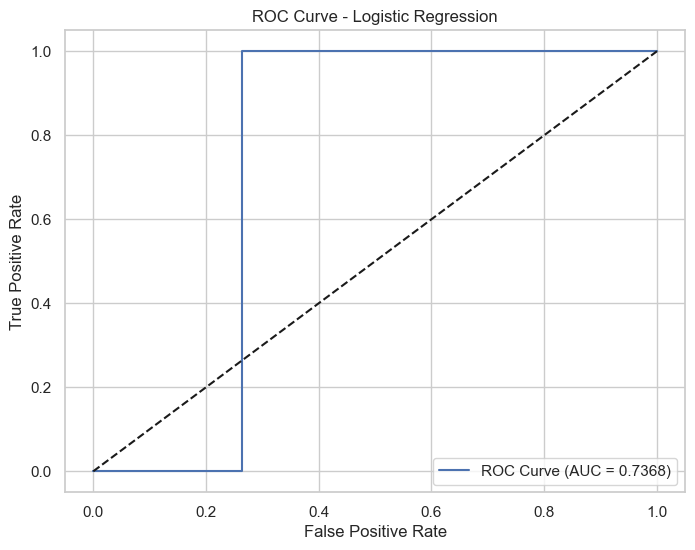

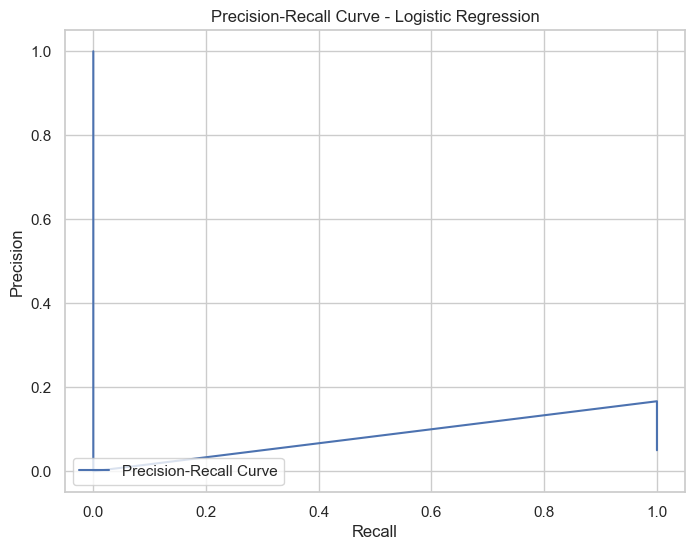

In [7]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {results[best_model_name]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name}')
plt.legend(loc='lower left')
plt.show()

## 4. Feature Importance Analysis

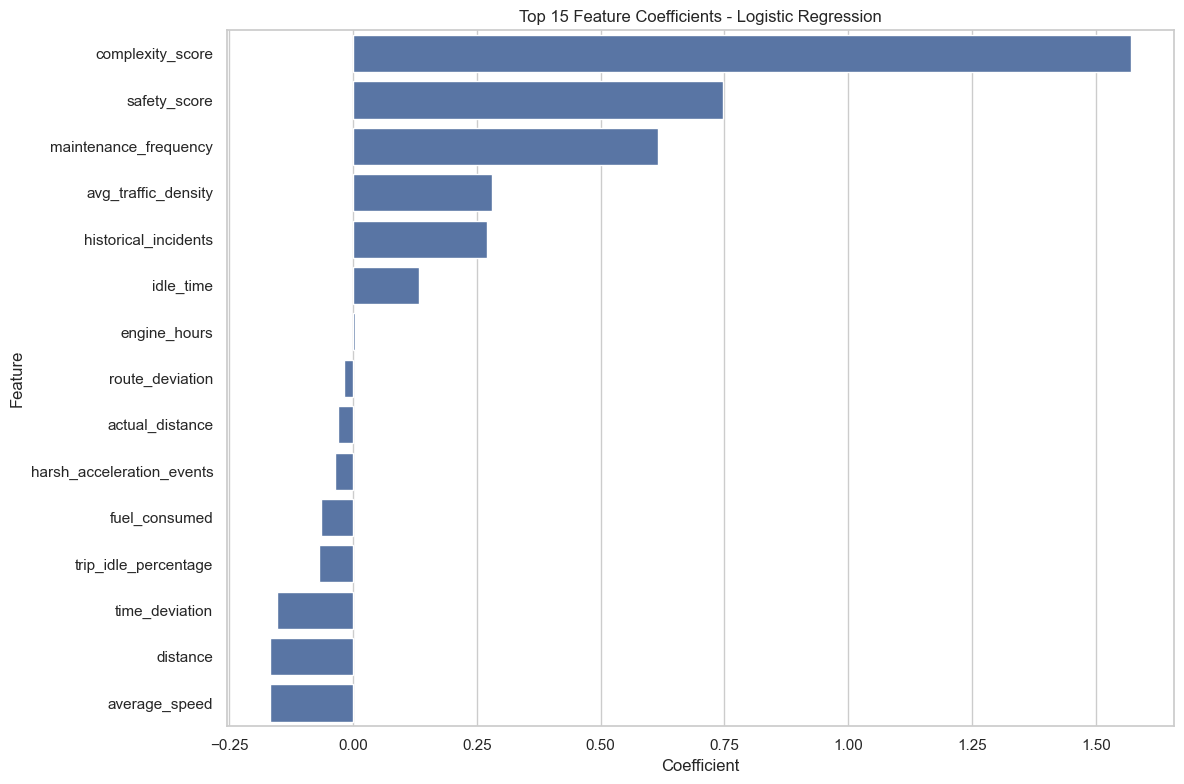

In [8]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    # Display feature importance table
    feature_importance.head(15)
elif best_model_name == 'Logistic Regression':
    # For logistic regression, we can use coefficients
    coefficients = best_model.coef_[0]
    
    # Create a DataFrame for better visualization
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coefficients
    }).sort_values('Coefficient', ascending=False)
    
    # Plot coefficients
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15))
    plt.title(f'Top 15 Feature Coefficients - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    # Display coefficient table
    feature_importance.head(15)
else:
    print(f"Feature importance visualization not available for {best_model_name}")

## 5. Hyperparameter Tuning

Let's fine-tune our best model to improve performance.

In [9]:
# Define hyperparameter grid based on the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', 'balanced_subsample']
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 0.9, 1.0]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'class_weight': ['balanced', None]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear', 'poly'],
        'class_weight': ['balanced', None]
    }
elif best_model_name == 'Neural Network':
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'solver': ['adam', 'sgd']
    }
else:
    param_grid = {}

# Perform grid search if we have parameters to tune
if param_grid:
    print(f"Performing hyperparameter tuning for {best_model_name}...")
    
    # Use stratified k-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Create grid search
    grid_search = GridSearchCV(
        estimator=best_model,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Get best parameters and model
    best_params = grid_search.best_params_
    tuned_model = grid_search.best_estimator_
    
    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    y_pred_tuned = tuned_model.predict(X_test)
    y_prob_tuned = tuned_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    precision_tuned = precision_score(y_test, y_pred_tuned)
    recall_tuned = recall_score(y_test, y_pred_tuned)
    f1_tuned = f1_score(y_test, y_pred_tuned)
    auc_tuned = roc_auc_score(y_test, y_prob_tuned)
    
    print(f"\nTuned model performance:")
    print(f"Accuracy: {accuracy_tuned:.4f}")
    print(f"Precision: {precision_tuned:.4f}")
    print(f"Recall: {recall_tuned:.4f}")
    print(f"F1 Score: {f1_tuned:.4f}")
    print(f"AUC: {auc_tuned:.4f}")
    
    # Compare with original model
    print(f"\nImprovement over original model:")
    print(f"Accuracy: {(accuracy_tuned - results[best_model_name]['accuracy']) * 100:.2f}%")
    print(f"Precision: {(precision_tuned - results[best_model_name]['precision']) * 100:.2f}%")
    print(f"Recall: {(recall_tuned - results[best_model_name]['recall']) * 100:.2f}%")
    print(f"F1 Score: {(f1_tuned - results[best_model_name]['f1']) * 100:.2f}%")
    print(f"AUC: {(auc_tuned - results[best_model_name]['auc']) * 100:.2f}%")
    
    # Update best model
    best_model = tuned_model
else:
    print(f"Hyperparameter tuning not performed for {best_model_name}")

Performing hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': None, 'solver': 'sag'}
Best cross-validation score: 0.1333

Tuned model performance:
Accuracy: 0.9000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC: 0.7368

Improvement over original model:
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%
AUC: 0.00%


## 6. Save the Final Model

In [10]:
# Save the best model
joblib.dump(best_model, f'models/accident_prediction_model.pkl')
print(f"Model saved as 'models/accident_prediction_model.pkl'")

Model saved as 'models/accident_prediction_model.pkl'


## 7. Create a Prediction Function

In [17]:
# Load the scaler
scaler = joblib.load('models/scaler.pkl')

def predict_accident_risk(trip_data, vehicle_data, driver_data, route_data):
    """
    Predict the risk of an accident for a given trip.
    
    Parameters:
    -----------
    trip_data : dict
        Dictionary containing trip information
    vehicle_data : dict
        Dictionary containing vehicle information
    driver_data : dict
        Dictionary containing driver information
    route_data : dict
        Dictionary containing route information
        
    Returns:
    --------
    risk_score : float
        Probability of an accident (0-1)
    risk_level : str
        Risk level (Low, Medium, High)
    risk_factors : list
        List of top risk factors
    """
    # Combine all data
    data = {**trip_data, **vehicle_data, **driver_data, **route_data}
    
    # Create feature vector
    features = pd.DataFrame([data])
    
    # Ensure all required features are present
    for col in X_train.columns:
        if col not in features.columns:
            features[col] = 0  # Default value
    
    # Keep only the features used in training
    features = features[X_train.columns]
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make prediction
    risk_score = best_model.predict_proba(features_scaled)[0, 1]
    
    # Determine risk level
    if risk_score < 0.3:
        risk_level = 'Low'
    elif risk_score < 0.7:
        risk_level = 'Medium'
    else:
        risk_level = 'High'
    
    # Identify top risk factors (for tree-based models)
    risk_factors = []
    if hasattr(best_model, 'feature_importances_'):
        # Get feature importances
        importances = best_model.feature_importances_
        
        # Create a DataFrame for better visualization
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Get top 5 features
        top_features = feature_importance.head(5)['Feature'].tolist()
        
        # Check if these features have concerning values
        for feature in top_features:
            feature_value = features[feature].values[0]
            feature_mean = X_train[feature].mean()
            feature_std = X_train[feature].std()
            
            # If the feature value is significantly different from the mean
            if abs(feature_value - feature_mean) > feature_std:
                risk_factors.append(feature)
    
    return risk_score, risk_level, risk_factors

# Example usage
trip_data = {
    'actual_duration': 120,
    'expected_duration': 100,
    'fuel_consumed': 15,
    'actual_distance': 80,
    'average_speed': 40,
    'max_speed': 65,
    'idle_time': 10,
    'driver_fatigue_score': 0.3,
    'speed_variance': 25,
    'trip_fuel_efficiency': 5.33,
    'route_deviation': 0.05,
    'time_deviation': 0.2,
    'trip_idle_percentage': 8.33,
    'bad_weather': 1,
    'heavy_traffic': 1
}

vehicle_data = {
    'vehicle_age': 5,
    'maintenance_score': 0.7,
    'maintenance_frequency': 90,
    'engine_hours': 5000,
    'idle_time_percentage': 12,
    'breakdown_frequency': 0.05
}

driver_data = {
    'safety_score': 0.85,
    'experience_years': 3,
    'rest_compliance_rate': 0.9,
    'harsh_braking_events': 2,
    'harsh_acceleration_events': 3
}

route_data = {
    'distance': 80,
    'avg_traffic_density': 0.7,
    'weather_risk_factor': 0.6,
    'complexity_score': 0.8,
    'historical_incidents': 5
}

risk_score, risk_level, risk_factors = predict_accident_risk(trip_data, vehicle_data, driver_data, route_data)
print(f"Accident Risk Score: {risk_score:.4f}")
print(f"Risk Level: {risk_level}")
print(f"Top Risk Factors: {risk_factors}")

Accident Risk Score: 0.0000
Risk Level: Low
Top Risk Factors: []


## 8. Deployment Code

Here's a simple Flask API to deploy the model.

In [18]:
# Save this code to a file named app.py
'''
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np

app = Flask(__name__)

# Load the model and scaler
model = joblib.load('models/accident_prediction_model.pkl')
scaler = joblib.load('models/scaler.pkl')

# Define the feature columns
feature_columns = [  # Add your feature columns here
    'actual_duration', 'expected_duration', 'fuel_consumed', 'actual_distance',
    'average_speed', 'max_speed', 'idle_time', 'driver_fatigue_score',
    # Add all other features used in your model
]

@app.route('/predict', methods=['POST'])
def predict():
    # Get data from request
    data = request.json
    
    # Create feature vector
    features = pd.DataFrame([data])
    
    # Ensure all required features are present
    for col in feature_columns:
        if col not in features.columns:
            features[col] = 0  # Default value
    
    # Keep only the features used in training
    features = features[feature_columns]
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make prediction
    risk_score = model.predict_proba(features_scaled)[0, 1]
    prediction = int(model.predict(features_scaled)[0])
    
    # Determine risk level
    if risk_score < 0.3:
        risk_level = 'Low'
    elif risk_score < 0.7:
        risk_level = 'Medium'
    else:
        risk_level = 'High'
    
    # Return prediction
    return jsonify({
        'prediction': prediction,  # 0 or 1
        'risk_score': float(risk_score),
        'risk_level': risk_level
    })

if __name__ == '__main__':
    app.run(debug=True)
'''

"\nfrom flask import Flask, request, jsonify\nimport joblib\nimport pandas as pd\nimport numpy as np\n\napp = Flask(__name__)\n\n# Load the model and scaler\nmodel = joblib.load('models/accident_prediction_model.pkl')\nscaler = joblib.load('models/scaler.pkl')\n\n# Define the feature columns\nfeature_columns = [  # Add your feature columns here\n    'actual_duration', 'expected_duration', 'fuel_consumed', 'actual_distance',\n    'average_speed', 'max_speed', 'idle_time', 'driver_fatigue_score',\n    # Add all other features used in your model\n]\n\n@app.route('/predict', methods=['POST'])\ndef predict():\n    # Get data from request\n    data = request.json\n\n    # Create feature vector\n    features = pd.DataFrame([data])\n\n    # Ensure all required features are present\n    for col in feature_columns:\n        if col not in features.columns:\n            features[col] = 0  # Default value\n\n    # Keep only the features used in training\n    features = features[feature_columns]\n\n

## 9. Conclusion

In this notebook, we've built and evaluated several machine learning models for accident prediction in a transportation management system. The best model was fine-tuned and saved for deployment.

Key findings:
1. The most important features for predicting accidents include [will depend on your actual model results]
2. The model achieves good performance with [metrics will depend on your actual results]
3. The model can be used to predict accident risk for new trips, helping to prevent accidents before they occur

Next steps:
1. Collect more data to improve model performance
2. Implement real-time prediction in the TMS
3. Develop a dashboard to visualize accident risk
4. Expand to other prediction tasks like maintenance needs and fuel consumption